### IMPORT ALL LIBRARY

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import argmax
import PIL
import random
from PIL import Image 
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,InputLayer
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

# PART 1 (CREATING INPUT PIPELINES)

In [ ]:
# pip install tensorflow_datasets

In [ ]:
import tensorflow_datasets as tfds

# Train
train_fasion_mnist = tfds.as_numpy(tfds.load("fashion_mnist", split="train", batch_size=-1))
train, train_label   = train_fasion_mnist["image"], train_fasion_mnist["label"]

# Test
test_fasion_mnist  = tfds.as_numpy(tfds.load("fashion_mnist", split="test", batch_size=-1))
test_images, test_labels    = test_fasion_mnist["image"], test_fasion_mnist["label"]

print("Train Samples:", len(train))
print("Test Samples:",  len(test_images))
print(train.shape)

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.reshape((train_images.shape[0], train_images.shape[1],train_images.shape[2], 1))
test_images = test_images.reshape((test_images.shape[0], test_images.shape[1], test_images.shape[2], 1))

In [ ]:
# Resize and normalize the images before putting in the model
IMG_SIZE =28
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
# Create more images by augmenting the images using flipping , Rotation and zooming the images
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2,fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2),
])

In [ ]:
# All the classes of the images to predict
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
# Augment the images and stack the results with the previous images 
augmented_image1 = data_augmentation(train_images)
# augmented_image2 = data_augmentation(augmented_image1)
train_images = tf.concat([train_images,augmented_image1],0)
train_labels = tf.concat([train_labels]*2,0)

In [ ]:
print(train_images.shape)
print(train_labels.shape)

(120000, 28, 28, 1)
(120000,)


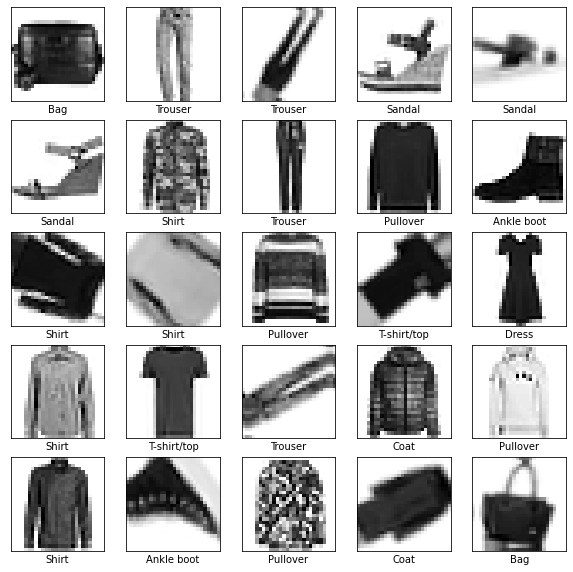

In [ ]:
# Plotting the training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    p = random.randint(0,train_images.shape[0])
    plt.imshow(train_images[p], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[p]])
plt.show()

In [ ]:
# plot learning curves
def summarize_results(histories):
    # plot loss
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()

    # plot accuracy
    plt.subplot(212)
    plt.ylabel('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()

    plt.show()
 

# PART 2 

### Base model without dropout, normalization and regularization parameter

In [ ]:
def create_model():
    model = Sequential()
    model.add(resize_and_rescale)
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [ ]:
def model_checkpoint(path):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback

In [ ]:
filepath = './fashion_mnist/base_model_checkpoint'

In [ ]:
model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit the model
history = model.fit(train_images, train_labels, epochs=25, batch_size=512,
                    callbacks=[model_checkpoint(filepath)], validation_data = (test_images, test_labels))

Epoch 1/25
235/235 [==============================] - 57s 235ms/step - loss: 1.0093 - accuracy: 0.6353 - val_loss: 0.5221 - val_accuracy: 0.8044
INFO:tensorflow:Assets written to: ./fashion_mnist\base_model_checkpoint\assets
Epoch 2/25
235/235 [==============================] - 57s 245ms/step - loss: 0.6769 - accuracy: 0.7521 - val_loss: 0.4133 - val_accuracy: 0.8526
INFO:tensorflow:Assets written to: ./fashion_mnist\base_model_checkpoint\assets
Epoch 3/25
235/235 [==============================] - 58s 247ms/step - loss: 0.5844 - accuracy: 0.7868 - val_loss: 0.3893 - val_accuracy: 0.8584
INFO:tensorflow:Assets written to: ./fashion_mnist\base_model_checkpoint\assets
Epoch 4/25
235/235 [==============================] - 58s 245ms/step - loss: 0.5305 - accuracy: 0.8054 - val_loss: 0.3452 - val_accuracy: 0.8783
INFO:tensorflow:Assets written to: ./fashion_mnist\base_model_checkpoint\assets
Epoch 5/25
235/235 [==============================] - 58s 245ms/step - loss: 0.4902 - accuracy: 0.81

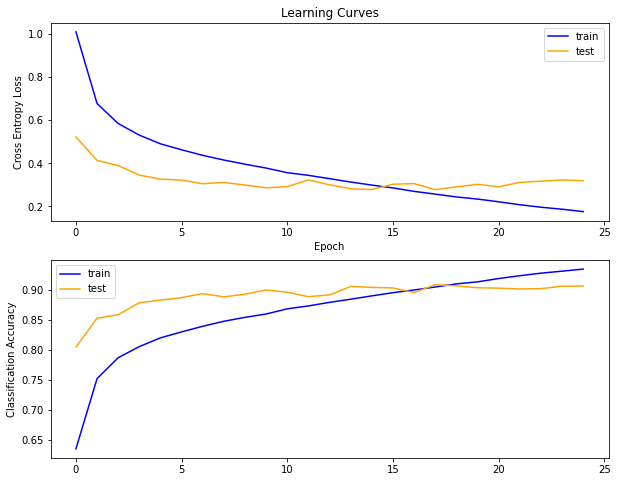

In [ ]:
summarize_results(history)

In [ ]:
# Loading the best model
model = tf.keras.models.load_model(filepath)

In [ ]:
# evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=3)
print('Test Accuracy: %.4f' % acc)

Test Accuracy: 0.9083


In [ ]:
predictions = np.argmax(model.predict(test_images, verbose=0),axis=1)

In [ ]:
print(confusion_matrix(test_labels, predictions))


[[843   1  18  16   6   0 107   0   8   1]
 [  2 984   0   7   3   0   2   0   2   0]
 [ 14   1 859  10  46   0  69   0   1   0]
 [ 13  10   9 896  37   0  30   0   5   0]
 [  1   2  41  16 864   1  71   0   4   0]
 [  0   0   0   1   0 976   0  12   1  10]
 [ 96   3  54  22  55   0 755   0  15   0]
 [  0   0   0   0   0  12   0 975   1  12]
 [  0   2   2   3   3   6   4   2 978   0]
 [  0   0   0   0   0   5   0  40   2 953]]


In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1000
           1       0.98      0.98      0.98      1000
           2       0.87      0.86      0.87      1000
           3       0.92      0.90      0.91      1000
           4       0.85      0.86      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.73      0.76      0.74      1000
           7       0.95      0.97      0.96      1000
           8       0.96      0.98      0.97      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



# PART 3

### Model with Batch normalization, dropout, ReduceLRonPlateau and early stopping to tackle overfitting

In [1]:
def create_model():
    model = Sequential()
    model.add(resize_and_rescale)
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [1]:
model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = './fashion_mnist/updated_model_checkpoint'

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=0.0001)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [ ]:
# fit the model
history = model.fit(train_images, train_labels, epochs=25, batch_size=512,
                    callbacks=[model_checkpoint(filepath),reduce_lr,early_stopping],
                    validation_data = (test_images, test_labels))

In [ ]:
summarize_results(history)

In [ ]:
model = tf.keras.models.load_model(filepath)

In [ ]:
# evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=3)
print('Test Accuracy: %.4f' % acc)

In [ ]:
predictions = np.argmax(model.predict(test_images, verbose=0),axis=1)

In [ ]:
print(confusion_matrix(test_labels, predictions))

In [ ]:
print(classification_report(test_labels, predictions))

## INCORRECT PREDICTED IMAGES

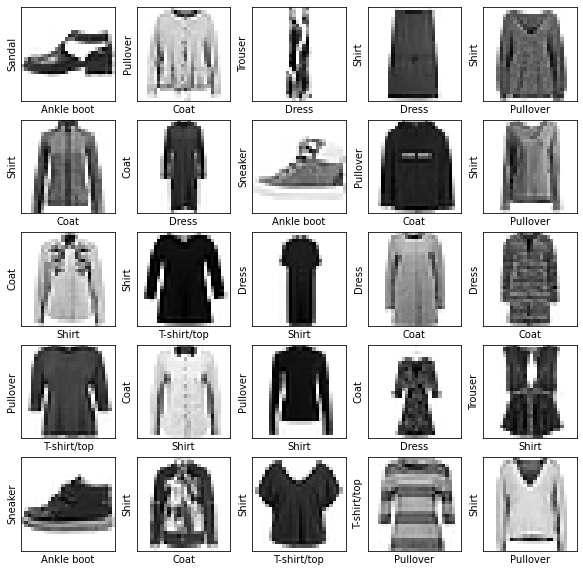

In [ ]:
c=0
plt.figure(figsize=(10,10))
for i in range(len(predictions)):
    if(c>=25):break
    if(test_labels[i]!=predictions[i]):
        c=c+1
        plt.subplot(5,5,c)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[test_labels[i]])
        plt.ylabel(class_names[predictions[i]])
plt.show()

## Cross Check the models

In [ ]:
filepath1 = './fashion_mnist/base_model_checkpoint'
filepath2 = './fashion_mnist/updated_model_checkpoint'

model = tf.keras.models.load_model(filepath2)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 64)       

In [ ]:
def data_processing(image):
    image  = image.resize((28,28))
    image=np.array(image)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.axis('off')
    plt.show()
    image = image.reshape((1, 28, 28, 1))
    return image

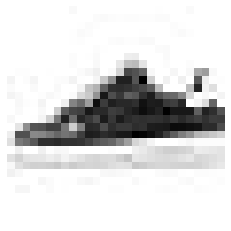

Predicted class of the image is:  Sneaker


In [ ]:
image = Image.open('pic1.jpg')
image = data_processing(image)
pred = np.argmax(model.predict(image))
print("Predicted class of the image is: ",class_names[pred])

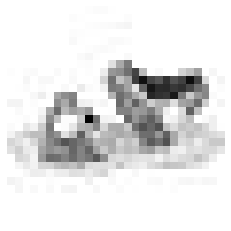

Predicted class of the image is:  Sandal


In [ ]:
image = Image.open('pic2.jpg')
image = data_processing(image)
pred = np.argmax(model.predict(image))
print("Predicted class of the image is: ",class_names[pred])

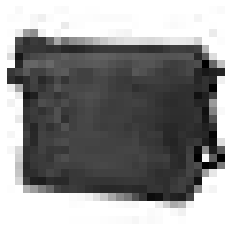

Predicted class of the image is:  Bag


In [ ]:
image = Image.open('pic3.jpg')
image = data_processing(image)
pred = np.argmax(model.predict(image))
print("Predicted class of the image is: ",class_names[pred])